In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as its
import sys
import time
import os
import string

import tensorflow as tf

import keras
import keras.backend as K
import keras.preprocessing.sequence as pps
import keras.layers.wrappers as wrappers



Using TensorFlow backend.


In [2]:

# We get rid of most possible characters:
chars_to_keep = string.ascii_lowercase  + string.digits + ' ' + ',' + '.' + '?' + '!' + '(' + ')' + '/' + ':' + ';' + '\"'

char_to_idx = { c : i for i, c in enumerate(chars_to_keep)}
idx_to_char = {i : c for i, c in enumerate(chars_to_keep)}




def string_to_array(s):
    # map maybe_char() to input to remove uncomon characters:
    def maybe_char(c):
        if c in chars_to_keep:
            return c
        return ""
    # Return a numpy array
    return np.array([char_to_idx[c] for c in "".join(map(maybe_char, s.lower()))], np.int8)



def get_data(folder='aclImdb', files_to_use=1.0, max_len=800, train_data=True):
    # Takes the first files_to_use files from both folders (max 25000 of each) and pads with zeros to max_len
    
    if train_data:
        folder += '/train'
    else:
        folder += '/test'
        
    X = []
    X_lengths = []
    lengths = []
    sub_folders = ['pos', 'neg']
    for sub_folder in sub_folders:
        path = folder + '/' + sub_folder + "/"
        files = os.listdir(path)
        
        # Only take the fraction files_to_use 
        files = files[:int(len(files)*files_to_use)]
        lengths.append(len(files))

        for fn in files:

            try:
                f = file(path + fn, 'r')
                ss = f.read()
                f.close()
            except Exception as e:
                print "Could not open file %s, error: %s %s %s"% (fn, type(e), e.__str__(), sys.exc_info()[0])
            
            X.append(string_to_array(ss))
            X_lengths.append(len(ss))

    # Add one and so that we pad with zeros (zeros will be masked). First only positive, then negative.
    X = keras.preprocessing.sequence.pad_sequences(X, max_len, dtype='int32', value=-1) + 1
    y = np.concatenate((np.ones(lengths[0]), np.zeros(lengths[1])))
    
    np.random.seed(7)
    np.random.shuffle(X)
    
    np.random.seed(7)
    np.random.shuffle(y)
    
    return X, y[:, np.newaxis], X_lengths
    

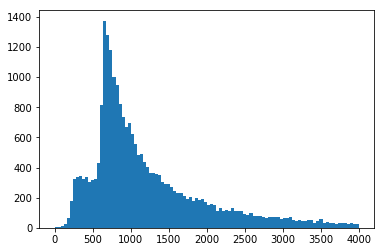

In [3]:
plt.hist(get_data(max_len=5000)[2], bins=100, range=(0,4000))
plt.show()

(25003, 600)

In [3]:
X, y, lengths = get_data(max_len=600)


In [75]:
m = keras.models.Sequential()

one_hot_embedding_lookup = np.concatenate((np.zeros((len(chars_to_keep), 1)), np.eye(len(chars_to_keep))), axis=1).T

m.add( keras.layers.Embedding(len(chars_to_keep) + 1, len(chars_to_keep), mask_zero=True, trainable=False, weights=[one_hot_embedding_lookup]) )
#m.add( keras.layers.LSTM(128, return_sequences=True))
#m.add( keras.layers.Dropout(0.4))
m.add( keras.layers.LSTM(128))
#m.add( keras.layers.Dropout(0.4))
m.add( keras.layers.Dense(len(chars_to_keep) + 1, activation='softmax') )

m.compile('rmsprop', loss='sparse_categorical_crossentropy' )






In [76]:
history_list = []

In [ ]:
batch_size = 128
n_timesteps = 10
n_epochs = 10

for _ in range(n_epochs):
    for i in range(0, X.shape[1] - n_timesteps - 1):
        history_list.append(m.fit(X[:, i:i+n_timesteps], X[:, i+n_timesteps, np.newaxis], validation_split=0.10, shuffle=False, batch_size=batch_size, epochs=1 ))




/usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 42s - loss: 3.1477 - val_loss: 3.0318
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 38s - loss: 2.9708 - val_loss: 2.8254
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 46s - loss: 2.7537 - val_loss: 2.6356
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 49s - loss: 2.6098 - val_loss: 2.4978
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 48s - loss: 2.5032 - val_loss: 2.3940
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 43s - loss: 2.4349 - val_loss: 2.3739
Train on 22502 samples, validate on 2501 samples
Epoch 1/1
22502/22502 [==============================] - 43s - loss: 2.3574 - val_loss:

In [25]:
def generate_char(m, text=""):
     return np.random.choice( ['_'] + list(chars_to_keep), p=m.predict(string_to_array(text)[np.newaxis, :])[0])
    
def generate_text(m, N, text="k"): # start with one character so that m.predict works.
    for i in range(N):
        text += generate_char(m, text)
    return text

In [ ]:
generate_text(m, 100)